# Envinroment set-up

In [ ]:
# Change the following directory path according to the path in your drive
datasets_path = "/content/drive/MyDrive/Projeto - Segment Anything Model/codigo-notebook/datasets"
# datasets_path = other..

In [ ]:
# If you are using Google Colab
from google.colab import drive
drive.mount('/content/drive')

from google.colab.patches import cv2_imshow

In [ ]:
# Import libraries
from glob import glob
from pathlib import Path
from shutil import copy

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
import pandas as pd

import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

In [ ]:
# Hide colab cell output with %%capture
!pip install -q gwpy

In [ ]:
# Install dependencies (SAM included)
%%capture
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
# SAM set-up
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [ ]:
# Define prediction visualization functions
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In [ ]:
# Define the bounding box and centroid identification functions
# find1 succeds at correctly identifying for all masks, but 243.bmp from dataset3
# find2 was created to treat the special case of the mask 243.bmp from dataset3

def find1_bboxs_and_centroids(mask_image):
    # Only works for masks in which the leukocytes don't coincide
    min_contour_area = 10
    contours, _ = cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= min_contour_area]
    bboxs = [cv2.boundingRect(cnt) for cnt in contours]
    centroids = []
    for x, y, w, h in bboxs:
        cx, cy = x + w // 2, y + h // 2
        centroids.append((cx, cy))
    return bboxs, centroids


def find2_bboxs_and_centroids(mask_image):
    # Only works for masks in which each leukocyte has an outer area of the same
    # color that encompasses all other parts of the leukocyte
    bboxs = []
    centroids_list = []

    for grayscale_value in np.unique(mask_image):
        if grayscale_value == 0:
            continue

        binary_mask = np.zeros_like(mask_image)
        binary_mask[mask_image == grayscale_value] = 255
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

        for label in range(1, num_labels):
            x, y, w, h = stats[label, cv2.CC_STAT_LEFT], stats[label, cv2.CC_STAT_TOP], \
                           stats[label, cv2.CC_STAT_WIDTH], stats[label, cv2.CC_STAT_HEIGHT]
            bboxs.append((x, y, w, h))
            cx, cy = int(centroids[label, 0]), int(centroids[label, 1])
            centroids_list.append((cx, cy))

    outer_bboxs = []
    outer_centroids_list = []
    for i, bbox in enumerate(bboxs):
        x, y, w, h = bbox
        is_contained = False
        for j, other_bbox in enumerate(bboxs):
            if i == j:
                continue
            x1, y1, w1, h1 = other_bbox
            if x >= x1 and y >= y1 and x + w <= x1 + w1 and y + h <= y1 + h1:
                is_contained = True
                break

        if not is_contained:
            outer_bboxs.append((x, y, w, h))
            outer_centroids_list.append(centroids_list[i])

    return outer_bboxs, outer_centroids_list

In [ ]:
# Define evaluation metrics functions
def iou(gt_mask, pred_mask):
    gt_mask = np.asarray(gt_mask).astype(bool)
    pred_mask = np.asarray(pred_mask).astype(bool)
    intersect = np.sum(pred_mask * gt_mask)
    union = np.sum(pred_mask) + np.sum(gt_mask) - intersect
    iou = np.mean(intersect / union)
    return round(iou, 4)

def dice(gt_mask, pred_mask, empty_score=1.0):
    gt_mask = np.asarray(gt_mask).astype(bool)
    pred_mask = np.asarray(pred_mask).astype(bool)
    intersect = np.sum(pred_mask * gt_mask)
    total_sum = np.sum(pred_mask) + np.sum(gt_mask)

    if total_sum == 0:
        return empty_score
    dice = np.mean(2 * intersect / total_sum)
    return round(dice, 4)

# Segmentation with manual prompt

In [ ]:
# Load image and ground truth mask
example_img = cv2.imread(datasets_path+"/dataset01/image/007.bmp")
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
gt_mask = cv2.imread(datasets_path+"/dataset01/mask/007.png", cv2.IMREAD_GRAYSCALE)

# Segmentation points
points = np.array([[55, 61]])
labels = np.ones(points.shape[0])

# Examples in dataset03:
# (010) neutrophil   with point [345, 305]
# (098) lymphocyte   with point [450, 250]
# (145) monocyte     with point [50, 340]
# (182) eosinophil   with point [275, 195]
# (198) basophil     with point [150, 225]
# (243) mixture      with points [195, 435], [550, 200], [575, 268]

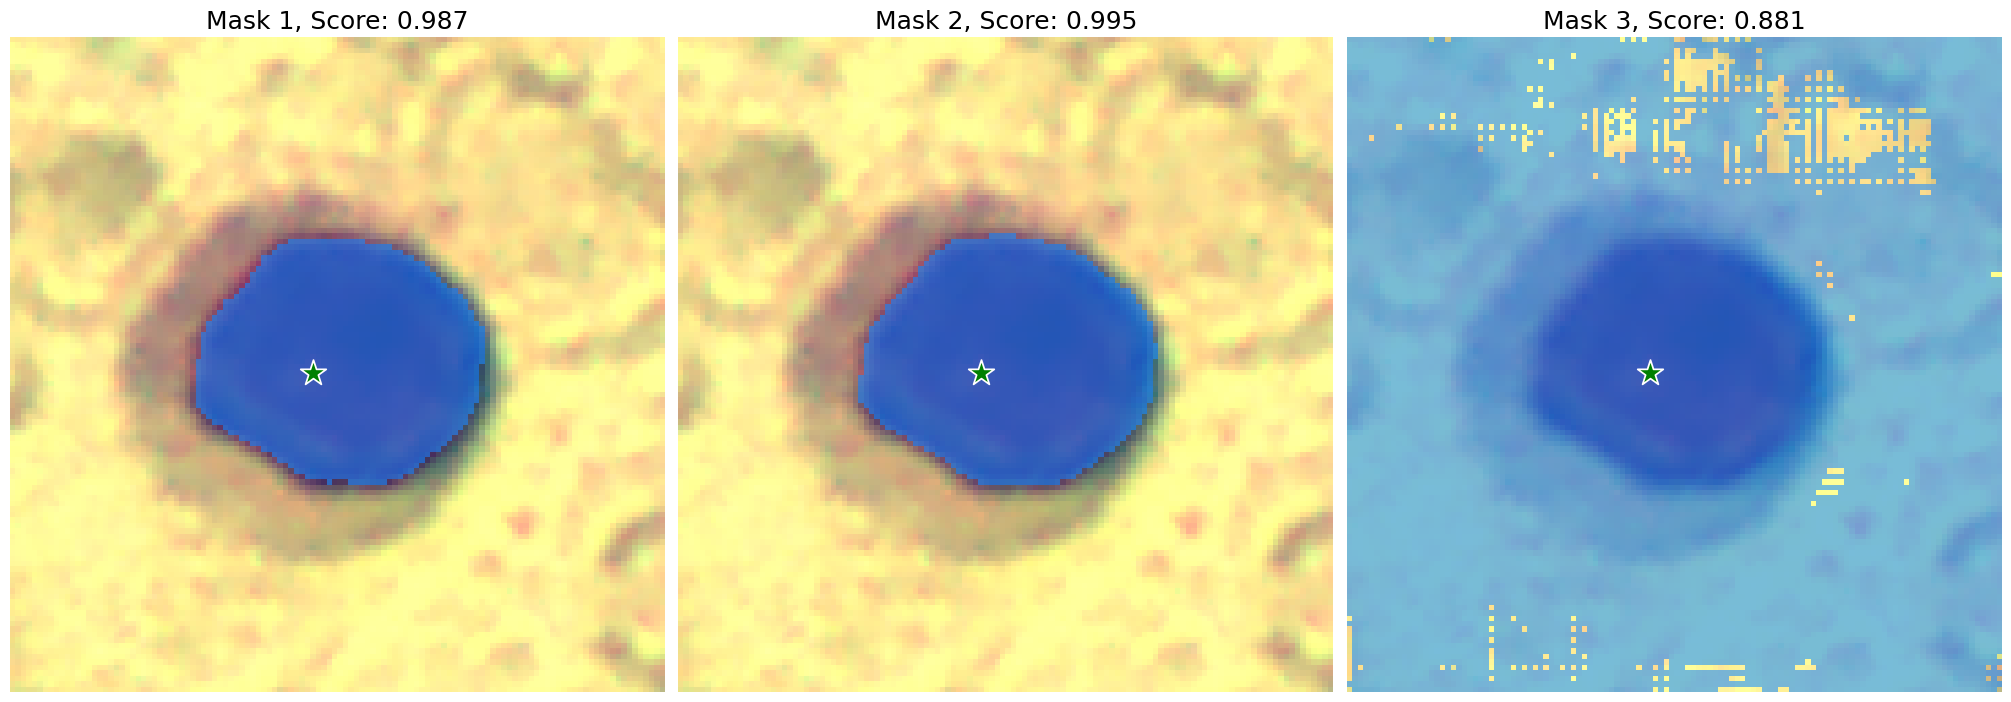

In [ ]:
# Prediction of the segmentation
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    point_coords=points,
    point_labels=labels,
    multimask_output=True,
)

fig = plt.figure(figsize=(20, 10), constrained_layout=True)
rows, columns = 1, 3
for i, (mask, score) in enumerate(zip(masks, scores)):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(example_img)
    show_mask(mask, plt.gca())
    show_points(points, labels, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')

In [ ]:
# Calculate evaluation metrics after resizing the mask (preserves aspect ratio)
gt_resized = cv2.resize(gt_mask, (masks[i, :, :]).shape[::-1])
iou_vals = []
dice_vals = []
for i in range(masks.shape[0]):
    iou_vals.append(iou(gt_resized, masks[i, :, :]))
    dice_vals.append(dice(gt_resized, masks[i, :, :]))

print("Metric values after resizing the mask, preserving aspect ratio (relevant only for dataset3):")
print()
print(f"IoU (default) = {iou_vals[np.argmax(scores)]} (mask {np.argmax(scores)+1})")
print(f"Dice (default) = {dice_vals[np.argmax(scores)]} (mask {np.argmax(scores)+1})")
print(f"IoU (oracle) = {iou_vals[np.argmax(iou_vals)]} (mask {np.argmax(iou_vals)+1})")
print(f"Dice (oracle) = {dice_vals[np.argmax(iou_vals)]} (mask {np.argmax(iou_vals)+1})")

Metric values after resizing the mask, preserving aspect ratio (relevant only for dataset3):

IoU (default) = 0.9125 (mask 3)
Dice (default) = 0.9542 (mask 3)
IoU (oracle) = 0.9125 (mask 3)
Dice (oracle) = 0.9542 (mask 3)


In [ ]:
# Calculate evaluation metrics after adding padding to the mask
image_height, image_width = example_img.shape[:-1]
mask_height, mask_width = gt_mask.shape
pad_top = (image_height - mask_height) // 2
pad_bottom = image_height - mask_height - pad_top
pad_left = (image_width - mask_width) // 2
pad_right = image_width - mask_width - pad_left
gt_resized = np.pad(gt_mask, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)

iou_vals = []
dice_vals = []
for i in range(masks.shape[0]):
    iou_vals.append(iou(gt_resized, masks[i, :, :]))
    dice_vals.append(dice(gt_resized, masks[i, :, :]))

print("Metric values after adding padding to the mask (relevant only for dataset3):")
print()
print(f"IoU (default) = {iou_vals[np.argmax(scores)]} (mask {np.argmax(scores)+1})")
print(f"Dice (default) = {dice_vals[np.argmax(scores)]} (mask {np.argmax(scores)+1})")
print(f"IoU (oracle) = {iou_vals[np.argmax(iou_vals)]} (mask {np.argmax(iou_vals)+1})")
print(f"Dice (oracle) = {dice_vals[np.argmax(iou_vals)]} (mask {np.argmax(iou_vals)+1})")

Metric values after adding padding to the mask (relevant only for dataset3):

IoU (default) = 0.8841 (mask 2)
Dice (default) = 0.9385 (mask 2)
IoU (oracle) = 0.8841 (mask 2)
Dice (oracle) = 0.9385 (mask 2)


# Segmentation with automatic prompt

[(96, 98, 109, 102)]

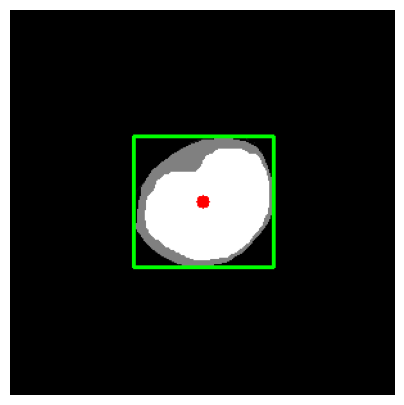

In [ ]:
# Example of bounding box and centroid identification using find1_bboxs_and_centroids
  # find1 succeds at correctly identifying for all masks, but 243.bmp from dataset3

gt_mask = cv2.imread(datasets_path+"/dataset02/mask/034.png", cv2.IMREAD_GRAYSCALE)
bboxs, centroids = find1_bboxs_and_centroids(gt_mask)
gt_mask_colored = cv2.cvtColor(gt_mask, cv2.COLOR_GRAY2BGR)

for x, y, w, h in bboxs:
    cv2.rectangle(gt_mask_colored, (x, y), (x + w, y + h), (0, 255, 0), 2)
for cx, cy in centroids:
    cv2.circle(gt_mask_colored, (cx, cy), 5, (255, 0, 0), -1)
display(bboxs)
plt.figure(figsize=(5,5))
plt.imshow(gt_mask_colored)
plt.axis('off')
plt.show()

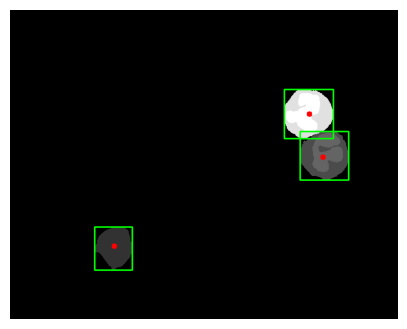

In [ ]:
# Example of bounding box and centroid identification using find2_bboxs_and_centroids
    # find2 was created to treat the special case of the mask 243.bmp from dataset3
gt_mask = cv2.imread(datasets_path+"/dataset03/mask/243.bmp", cv2.IMREAD_GRAYSCALE)
bboxs, centroids = find2_bboxs_and_centroids(gt_mask)
gt_mask_colored = cv2.cvtColor(gt_mask, cv2.COLOR_GRAY2BGR)

for x, y, w, h in bboxs:
    cv2.rectangle(gt_mask_colored, (x, y), (x + w, y + h), (0, 255, 0), 2)
for cx, cy in centroids:
    cv2.circle(gt_mask_colored, (cx, cy), 5, (255, 0, 0), -1)

plt.figure(figsize=(5,5))
plt.imshow(gt_mask_colored)
plt.axis('off')
plt.show()

In [ ]:
# Calculate the evaluation metrics for the point prompt in the images of the dataset1
default_iou1 = []
default_dice1 = []
oracle_iou1 = []
oracle_dice1 = []
dataset1_size = 300
for i in range(1, dataset1_size+1):
    img = cv2.imread(datasets_path + "/dataset01/image/" + str(i).zfill(3) + ".bmp")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gt_mask = cv2.imread(datasets_path+"/dataset01/mask/" + str(i).zfill(3) + ".png", cv2.IMREAD_GRAYSCALE)

    bboxs, centroids = find1_bboxs_and_centroids(gt_mask)
    points = np.array(centroids)
    labels = np.ones(points.shape[0])

    predictor.set_image(img)

    masks, scores, logits = predictor.predict(
        point_coords=points,
        point_labels=labels,
        multimask_output=True,
    )

    iou_vals = []
    dice_vals = []
    for i in range(masks.shape[0]):
        iou_vals.append(iou(gt_mask, masks[i, :, :]))
        dice_vals.append(dice(gt_mask, masks[i, :, :]))

    default_iou1.append(iou_vals[np.argmax(scores)])
    default_dice1.append(dice_vals[np.argmax(scores)])
    oracle_iou1.append(iou_vals[np.argmax(iou_vals)])
    oracle_dice1.append(dice_vals[np.argmax(iou_vals)])

print("Metric values for the point prompt in the images of the dataset1:")
print(f"IoU (default) = {sum(default_iou1) / len(default_iou1):.4f}")
print(f"Dice (default) = {sum(default_dice1) / len(default_dice1):.4f}")
print(f"IoU (oracle) = {sum(oracle_iou1) / len(oracle_iou1):.4f}")
print(f"Dice (oracle) = {sum(oracle_dice1) / len(oracle_dice1):.4f}")

Metric values for the point prompt in the images of the dataset1:
IoU (default) = 0.9144
Dice (default) = 0.9482
IoU (oracle) = 0.9411
Dice (oracle) = 0.9690


In [ ]:
# Calculate the evaluation metrics for the point prompt in the images of the dataset2
default_iou2 = []
default_dice2 = []
oracle_iou2 = []
oracle_dice2 = []
dataset1_size = 100
for i in range(1, dataset1_size+1):
    img = cv2.imread(datasets_path + "/dataset02/image/" + str(i).zfill(3) + ".bmp")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gt_mask = cv2.imread(datasets_path+"/dataset02/mask/" + str(i).zfill(3) + ".png", cv2.IMREAD_GRAYSCALE)

    bboxs, centroids = find1_bboxs_and_centroids(gt_mask)
    points = np.array(centroids)
    labels = np.ones(points.shape[0])

    predictor.set_image(img)

    masks, scores, logits = predictor.predict(
        point_coords=points,
        point_labels=labels,
        multimask_output=True,
    )

    iou_vals = []
    dice_vals = []
    for i in range(masks.shape[0]):
        iou_vals.append(iou(gt_mask, masks[i, :, :]))
        dice_vals.append(dice(gt_mask, masks[i, :, :]))

    default_iou2.append(iou_vals[np.argmax(scores)])
    default_dice2.append(dice_vals[np.argmax(scores)])
    oracle_iou2.append(iou_vals[np.argmax(iou_vals)])
    oracle_dice2.append(dice_vals[np.argmax(iou_vals)])

print("Metric values for the point prompt in the images of the dataset2:")
print(f"IoU (default) = {sum(default_iou2) / len(default_iou2):.4f}")
print(f"Dice (default) = {sum(default_dice2) / len(default_dice2):.4f}")
print(f"IoU (oracle) = {sum(oracle_iou2) / len(oracle_iou2):.4f}")
print(f"Dice (oracle) = {sum(oracle_dice2) / len(oracle_dice2):.4f}")

Metric values for the point prompt in the images of the dataset2:
IoU (default) = 0.7242
Dice (default) = 0.7967
IoU (oracle) = 0.9111
Dice (oracle) = 0.9488


In [ ]:
# Calculate the evaluation metrics for the bbox prompt in the images of the dataset1
default_iou3 = []
default_dice3 = []
oracle_iou3 = []
oracle_dice3 = []
dataset1_size = 300
for i in range(1, dataset1_size+1):
    img = cv2.imread(datasets_path + "/dataset01/image/" + str(i).zfill(3) + ".bmp")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gt_mask = cv2.imread(datasets_path+"/dataset01/mask/" + str(i).zfill(3) + ".png", cv2.IMREAD_GRAYSCALE)

    bboxs, centroids = find1_bboxs_and_centroids(gt_mask)

    xyxy = []
    for bbox in bboxs:
        xyxy.append((bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]))

    input_box = np.array(xyxy)

    predictor.set_image(img)

    masks, scores, logits = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=True,
    )

    iou_vals = []
    dice_vals = []
    for i in range(masks.shape[0]):
        iou_vals.append(iou(gt_mask, masks[i, :, :]))
        dice_vals.append(dice(gt_mask, masks[i, :, :]))

    default_iou3.append(iou_vals[np.argmax(scores)])
    default_dice3.append(dice_vals[np.argmax(scores)])
    oracle_iou3.append(iou_vals[np.argmax(iou_vals)])
    oracle_dice3.append(dice_vals[np.argmax(iou_vals)])

print("Metric values for the bbox prompt in the images of the dataset1:")
print(f"IoU (default) = {sum(default_iou3) / len(default_iou3):.4f}")
print(f"Dice (default) = {sum(default_dice3) / len(default_dice3):.4f}")
print(f"IoU (oracle) = {sum(oracle_iou3) / len(oracle_iou3):.4f}")
print(f"Dice (oracle) = {sum(oracle_dice3) / len(oracle_dice3):.4f}")

Metric values for the bbox prompt in the images of the dataset1:
IoU (default) = 0.9382
Dice (default) = 0.9675
IoU (oracle) = 0.9528
Dice (oracle) = 0.9756


In [ ]:
# Calculate the evaluation metrics for the bbox prompt in the images of the dataset2
default_iou4 = []
default_dice4 = []
oracle_iou4 = []
oracle_dice4 = []
dataset1_size = 100
for i in range(1, dataset1_size+1):
    img = cv2.imread(datasets_path + "/dataset02/image/" + str(i).zfill(3) + ".bmp")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gt_mask = cv2.imread(datasets_path+"/dataset02/mask/" + str(i).zfill(3) + ".png", cv2.IMREAD_GRAYSCALE)

    bboxs, centroids = find1_bboxs_and_centroids(gt_mask)

    xyxy = []
    for bbox in bboxs:
        xyxy.append((bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]))

    input_box = np.array(xyxy)

    predictor.set_image(img)

    masks, scores, logits = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=True,
    )

    iou_vals = []
    dice_vals = []
    for i in range(masks.shape[0]):
        iou_vals.append(iou(gt_mask, masks[i, :, :]))
        dice_vals.append(dice(gt_mask, masks[i, :, :]))

    default_iou4.append(iou_vals[np.argmax(scores)])
    default_dice4.append(dice_vals[np.argmax(scores)])
    oracle_iou4.append(iou_vals[np.argmax(iou_vals)])
    oracle_dice4.append(dice_vals[np.argmax(iou_vals)])

print("Metric values for the bbox prompt in the images of the dataset2:")
print(f"IoU (default) = {sum(default_iou4) / len(default_iou4):.4f}")
print(f"Dice (default) = {sum(default_dice4) / len(default_dice4):.4f}")
print(f"IoU (oracle) = {sum(oracle_iou4) / len(oracle_iou4):.4f}")
print(f"Dice (oracle) = {sum(oracle_dice4) / len(oracle_dice4):.4f}")

Metric values for the bbox prompt in the images of the dataset1:
IoU (default) = 0.9260
Dice (default) = 0.9613
IoU (oracle) = 0.9349
Dice (oracle) = 0.9662


In [ ]:
# Write the results to a CSV file
import csv
csv_file = "/content/drive/MyDrive/Projeto - Segment Anything Model/codigo-notebook/results/1.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['IoU(default)1', 'Dice(default)1', 'IoU(oracle)1', 'Dice(oracle)1'])
    for num1, num2, num3, num4 in zip(default_iou1, default_dice1, oracle_iou1, oracle_dice1):
        writer.writerow([num1, num2, num3, num4])

In [ ]:
# Write the results to a CSV file
import csv
csv_file = "/content/drive/MyDrive/Projeto - Segment Anything Model/codigo-notebook/results/2.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['IoU(default)2', 'Dice(default)2', 'IoU(oracle)2', 'Dice(oracle)2'])
    for num1, num2, num3, num4 in zip(default_iou2, default_dice2, oracle_iou2, oracle_dice2):
        writer.writerow([num1, num2, num3, num4])

In [ ]:
# Write the results to a CSV file
import csv
csv_file = "/content/drive/MyDrive/Projeto - Segment Anything Model/codigo-notebook/results/3.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['IoU(default)3', 'Dice(default)3', 'IoU(oracle)3', 'Dice(oracle)3'])
    for num1, num2, num3, num4 in zip(default_iou3, default_dice3, oracle_iou3, oracle_dice3):
        writer.writerow([num1, num2, num3, num4])

In [ ]:
# Write the results to a CSV file
import csv
csv_file = "/content/drive/MyDrive/Projeto - Segment Anything Model/codigo-notebook/results/4.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['IoU(default)4', 'Dice(default)4', 'IoU(oracle)4', 'Dice(oracle)4'])
    for num1, num2, num3, num4 in zip(default_iou4, default_dice4, oracle_iou4, oracle_dice4):
        writer.writerow([num1, num2, num3, num4])

# Results analysis

In [ ]:
import csv

csv_file = "/content/drive/MyDrive/Projeto - Segment Anything Model/codigo-notebook/results/1.csv"
default_iou1 = []
default_dice1 = []
oracle_iou1 = []
oracle_dice1 = []
with open(csv_file, mode='r') as file:
    reader = csv.reader(file)
    header = next(reader)  # Skip the header row
    for row in reader:
        # Assuming the data is in the same order as in the CSV file
        default_iou1.append(float(row[0]))
        default_dice1.append(float(row[1]))
        oracle_iou1.append(float(row[2]))
        oracle_dice1.append(float(row[3]))

In [ ]:
import csv

csv_file = "/content/drive/MyDrive/Projeto - Segment Anything Model/codigo-notebook/results/2.csv"
default_iou2 = []
default_dice2 = []
oracle_iou2 = []
oracle_dice2 = []
with open(csv_file, mode='r') as file:
    reader = csv.reader(file)
    header = next(reader)  # Skip the header row
    for row in reader:
        # Assuming the data is in the same order as in the CSV file
        default_iou2.append(float(row[0]))
        default_dice2.append(float(row[1]))
        oracle_iou2.append(float(row[2]))
        oracle_dice2.append(float(row[3]))

In [ ]:
import csv

csv_file = "/content/drive/MyDrive/Projeto - Segment Anything Model/codigo-notebook/results/3.csv"
default_iou3 = []
default_dice3 = []
oracle_iou3 = []
oracle_dice3 = []
with open(csv_file, mode='r') as file:
    reader = csv.reader(file)
    header = next(reader)  # Skip the header row
    for row in reader:
        # Assuming the data is in the same order as in the CSV file
        default_iou3.append(float(row[0]))
        default_dice3.append(float(row[1]))
        oracle_iou3.append(float(row[2]))
        oracle_dice3.append(float(row[3]))

In [ ]:
import csv

csv_file = "/content/drive/MyDrive/Projeto - Segment Anything Model/codigo-notebook/results/4.csv"
default_iou4 = []
default_dice4 = []
oracle_iou4 = []
oracle_dice4 = []
with open(csv_file, mode='r') as file:
    reader = csv.reader(file)
    header = next(reader)  # Skip the header row
    for row in reader:
        # Assuming the data is in the same order as in the CSV file
        default_iou4.append(float(row[0]))
        default_dice4.append(float(row[1]))
        oracle_iou4.append(float(row[2]))
        oracle_dice4.append(float(row[3]))

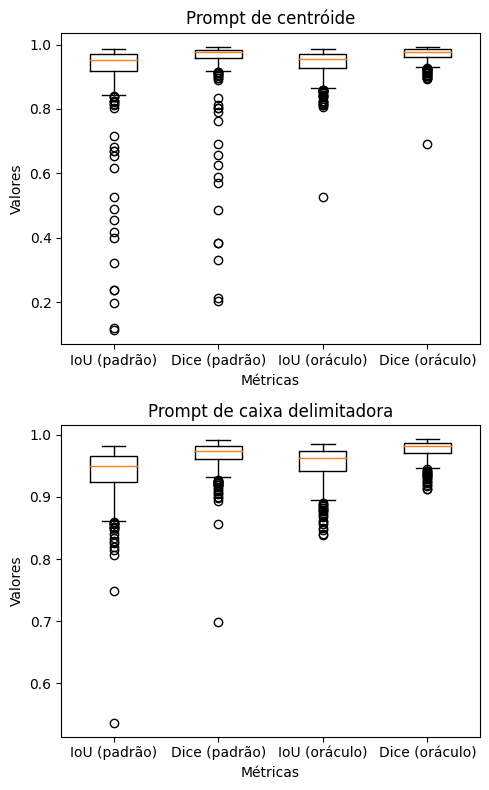

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 8))

plt.subplot(2, 1, 1)
plt.boxplot([default_iou1, default_dice1, oracle_iou1, oracle_dice1], labels=['IoU (padrão)', 'Dice (padrão)', 'IoU (oráculo)', 'Dice (oráculo)'])
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Prompt de centróide')

plt.subplot(2, 1, 2)
plt.boxplot([default_iou3, default_dice3, oracle_iou3, oracle_dice3], labels=['IoU (padrão)', 'Dice (padrão)', 'IoU (oráculo)', 'Dice (oráculo)'])
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Prompt de caixa delimitadora')

# Add labels and title for the entire figure
#plt.suptitle('Resultados dos experimentos na base 1')

# Adjust the layout for better spacing
plt.tight_layout()

plot_file_path = "/content/drive/MyDrive/Projeto - Segment Anything Model/codigo-notebook/results/box_plot_b1.pdf"
plt.savefig(plot_file_path, format='pdf')

# Display the combined box plots
plt.show()


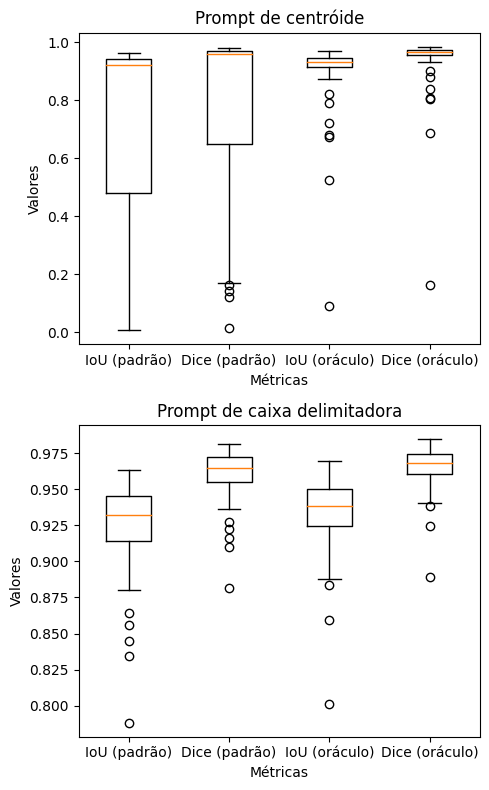

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 8))

plt.subplot(2, 1, 1)
plt.boxplot([default_iou2, default_dice2, oracle_iou2, oracle_dice2], labels=['IoU (padrão)', 'Dice (padrão)', 'IoU (oráculo)', 'Dice (oráculo)'])
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Prompt de centróide')

plt.subplot(2, 1, 2)
plt.boxplot([default_iou4, default_dice4, oracle_iou4, oracle_dice4], labels=['IoU (padrão)', 'Dice (padrão)', 'IoU (oráculo)', 'Dice (oráculo)'])
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Prompt de caixa delimitadora')

# Add labels and title for the entire figure
#plt.suptitle('Resultados dos experimentos na base 2')

# Adjust the layout for better spacing
plt.tight_layout()

plot_file_path = "/content/drive/MyDrive/Projeto - Segment Anything Model/codigo-notebook/results/box_plot_b2.pdf"
plt.savefig(plot_file_path, format='pdf')

# Display the combined box plots
plt.show()
